In [1]:
from scipy.integrate import odeint, solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Week of 6/21
Start embedding your model understanding into computational frameworks. So as an exercise, take a stab at implementing the Hodgkin Huxley model for numerical solution, e.g. using scipy (odeint or newer methods).

## Hodgkin-Huxley Model

In [2]:
def plot_vnmh(x,t):
    '''
    Callable function for plotting V,n,m,h
    
    Params:
        x: Matrix, each column is one of the above variables
        t: Time vector for x axis
    '''
    
    #plot the results
    plt.figure(figsize=(15,10))
    #Font sizes
    title_font = 20
    label_font = 15

    #Trying to stop them overlapping:
    #fig, ax = plt.subplots(2,1) #--> fig overwrites so I am no longer working on the subplots
    #fig.tight_layout(h_pad=2)
    #fig.suptitle('Overall Title')
    
    #Extract variables from matrix
    if x.shape[1] == 4:
        V = x[:,0]
        n = x[:,1]
        m = x[:,2]
        h = x[:,3]
        
        plt.subplot(211)
        plt.title("Voltage as a Function of Time", fontsize=title_font, fontweight="bold")
        plt.ylabel("Volts (mV)", fontsize=label_font)
        plt.xlabel("Time (ms)", fontsize=label_font)
        plt.plot(t,V)
        
        plt.subplot(212)
        plt.title("Gating Variables as a Function of Time", fontsize=title_font, fontweight="bold")
        plt.ylabel("Volts (mV)", fontsize=label_font)
        plt.xlabel("Time (ms)", fontsize=label_font)
        plt.plot(t,n,label="n")
        plt.plot(t,m,label="m")
        plt.plot(t,h,label="h")
        leg = plt.legend(loc='upper left')
        for text in leg.get_texts():
            text.set_color('black')
        plt.show()
        
    elif x.shape[0] == 10:
        V1 = x[0]
        n1 = x[1]
        m1 = x[2]
        h1 = x[3]
        s1 = x[4]
        V2 = x[5]
        n2 = x[6]
        m2 = x[7]
        h2 = x[8]
        s2 = x[9]
        
        plt.subplot(211)
        plt.title("Voltage as a Function of Time", fontsize=title_font, fontweight="bold")
        plt.ylabel("Volts (mV)", fontsize=label_font)
        plt.xlabel("Time (ms)", fontsize=label_font)
        plt.plot(t,V1,label="Neuron 1")
        plt.plot(t,V2,label="Neuron 2")
        leg = plt.legend(loc='upper left')
        for text in leg.get_texts():
            text.set_color('black')
        plt.show()
        
        plt.subplot(212)
        plt.title("Gating Variables as a Function of Time", fontsize=title_font, fontweight="bold")
        plt.ylabel("Volts (mV)", fontsize=label_font)
        plt.xlabel("Time (ms)", fontsize=label_font)
        plt.plot(t,n1,label="n1")
        plt.plot(t,m1,label="m1")
        plt.plot(t,h1,label="h1")
        plt.plot(t,n2,label="n2")
        plt.plot(t,m2,label="m2")
        plt.plot(t,h2,label="h2")
        leg = plt.legend(loc='upper left')
        for text in leg.get_texts():
            text.set_color('black')
        plt.show()

In [3]:
def odes(x0,t,I,vI):
    '''
    Defines the constants and differential equations for the base Hodgkin-Huxley equations
    
    Params:: 
        x0: ICs for V,n,m,h
        t: time vector, not sure if this is actually needed (not called in func)
        I: custom function, time varying current (square wave)
        vI: custom 3x1 vector for I function, just encapsulates the parameters needed for I to function
        
    Returns:: Differential equations of each variable as a vector
    '''
    
    #set ICs
    V = x0[0]
    n = x0[1]
    m = x0[2]
    h = x0[3]
    
    #Constants
    #Source: https://www.math.mcgill.ca/gantumur/docs/reps/RyanSicilianoHH.pdf
    #conductances (S is Siemens)
    gbarNa = 1.2 #mS/cm2
    gNa = gbarNa*(m**3)*h
    gbarK = 0.36 #mS/cm2
    gK = gbarK*(n**4)
    gbarL = 0.003 #mS/cm2
    gL = gbarL
    
    #reversal potentials
    ENa = 55.17 #mV
    EK = -72.14 #mV
    EL = -49.42 #mV
    #membrane capacitance
    Cm = 0.01 #uF/cm^2
    #Alpha and beta forms
    alpha_n = 0.01*(V+50)/(1-np.exp(-(V+50)/10))
    beta_n = 0.125*np.exp(-(V+60)/80)
    alpha_m = 0.1*(V+35)/(1-np.exp(-(V+35)/10))
    beta_m = 4.0*np.exp(-0.0556*(V+60))
    alpha_h = 0.07*np.exp(-0.05*(V+60))
    beta_h = 1/(1+np.exp(-0.1*(V+30)))

    #define each ODE
    dVdt = (1/Cm)*(gNa*(ENa-V) + gK*(EK-V) + gL*(EL-V) + I(t,vI))
    #dVdt = (gNa*(ENa-V) + gK*(EK-V) + gL*(EL-V) + I(t,vI))
    dndt = alpha_n*(1-n)-beta_n*n
    dmdt = alpha_m*(1-m)-beta_m*m
    dhdt = alpha_h*(1-h)-beta_h*h

    return dVdt, dndt, dmdt, dhdt

In [4]:
def I(t=0,vI=[0,0,0]):
    '''
    Determines the applied current, with respect to the HH model.  By default makes a square wave
    '''
    
    #Applied current
    t_start = vI[0]
    t_end = vI[1]
    amplitude = vI[2]
    
    applied_current = (t>=t_start)*(t<=t_end)*amplitude
    #Ie if t is within range [t_start,t_end], we apply some amount of current, amplitude
    #Recall: t>=C evaluates to a Boolean, which, when used numerically, is equivalent to 0 or 1
    return applied_current

BURN IN: instead of using the random, clean x0 initial conditions I found, we should use burn in to find what the true steady state of our system is.  I.e. let it run for a really long time and whatever it equilibriates to is what we will use for "true" SS going forward:

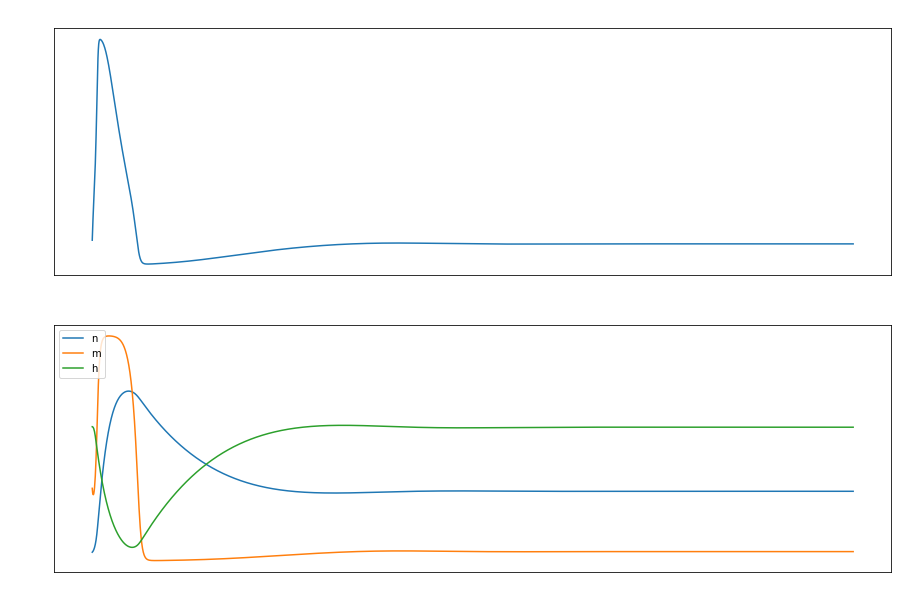

In [5]:
#initial condition: V, n, m, h
x0 = [-58, 0.05, 0.33, 0.6] #Found online... not sure if these are correct
#time vector
t = np.linspace(0,50,2000) #600
#vector needed 
vI = [0,0,0]

x = odeint(odes,x0,t,args=(I,vI))

V = x[:,0]
n = x[:,1]
m = x[:,2]
h = x[:,3]

plot_vnmh(x,t)

In [6]:
print("Comparing our original x0 to what our system of differntial equations seems to prefer as SS:")
print(x0)
x0_new = x[-1,:]
print(x0_new)

Comparing our original x0 to what our system of differntial equations seems to prefer as SS:
[-58, 0.05, 0.33, 0.6]
[-6.00470736e+01  3.16944630e-01  5.26385829e-02  5.97749949e-01]


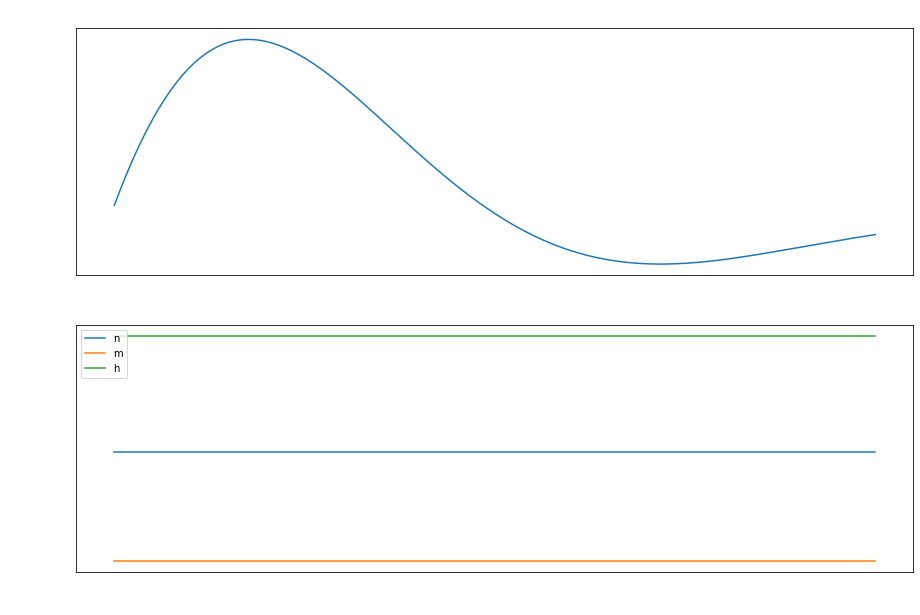

In [7]:
#BURNED IN initial condition
#time vector
t = np.linspace(0,15,1000)
x = odeint(odes,x0_new,t,args=(I,vI))

V = x[:,0]
n = x[:,1]
m = x[:,2]
h = x[:,3]

plot_vnmh(x,t)

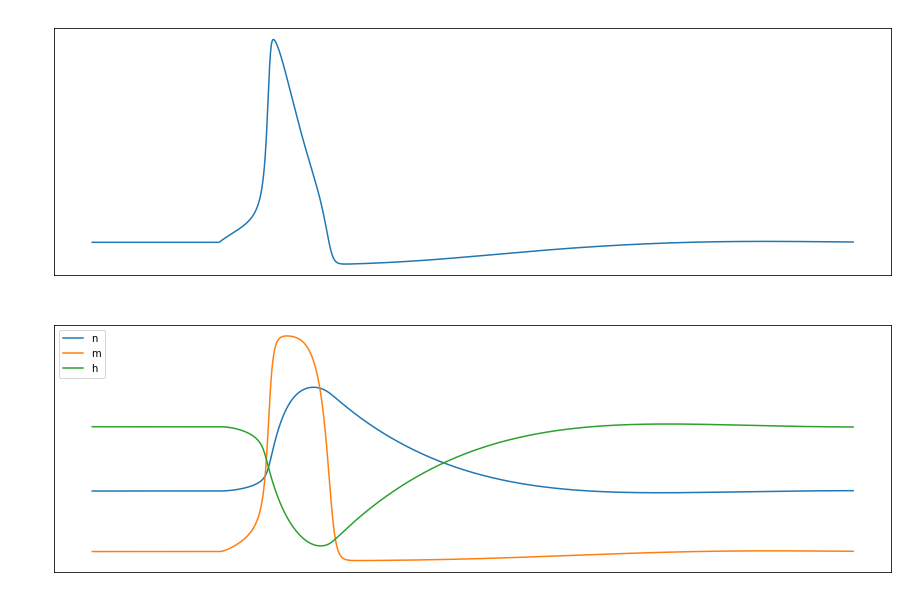

In [8]:
t = np.linspace(0,30,1000) #ms
#NOW SETTING vI to something realistic:
vI = [5,7,0.1]

x = odeint(odes,x0_new,t,args=(I,vI))

V = x[:,0]
n = x[:,1]
m = x[:,2]
h = x[:,3]

plot_vnmh(x,t)

## Tasks Post 6/23 Meeting:
2. SYNAPTICALLY COUPLED NEURONS: Choose the reversal potential to be the same as the sodium current (Excitatory synapse)
3. Start with synpatic g of 0 to verify 
4. Then begin increasing both g's --> numerically find some minimal set of g's, FIND SUSTAINED OSCILLATION OF CONTINUOUS SPIKING

In [6]:
def odes_scn(x0,t,I,vI_scn):
    '''
    Defines the constants and differential equations for the HH-compliant synaptically coupled neurons.
    
    Params:: 
        x0: ICs for V1,n1,m1,h1,s1,V2,n2,m2,h2,s2
        t: time vector, not sure if this is actually needed (not called in func)
        I: custom function, time varying current (square wave)
        vI_scn: custom 5x1 vector for I function, just encapsulates the parameters needed for I to function.  
          Also encapsulates the values for g1 and g2
        
    Returns:: Differential equations of each variable as a vector
    
    '''
        
    #set ICs
    V1 = x0[0]
    n1 = x0[1]
    m1 = x0[2]
    h1 = x0[3]
    s1 = x0[4]
    
    V2 = x0[5]
    n2 = x0[6]
    m2 = x0[7]
    h2 = x0[8]
    s2 = x0[9]
        
    #Constants
    #Source: https://www.math.mcgill.ca/gantumur/docs/reps/RyanSicilianoHH.pdf
    
    #conductances (S is Siemens)
    gbarNa = 1.2 #mS/cm2
    gNa1 = gbarNa*(m1**3)*h1
    gNa2 = gbarNa*(m2**3)*h2
    gbarK = 0.36 #mS/cm2
    gK1 = gbarK*(n1**4)
    gK2 = gbarK*(n2**4)
    gbarL = 0.003 #mS/cm2
    gL = gbarL
    
    #Passing g1/g2 through vI might not be the best approach...
    gbars1 = vI_scn[3]
    gs1 = gbars1*s1
    # ASSUMING S1 = S2, or for now, g1=g2
    gbars2 = vI_scn[4]
    gs2 = gbars2*s2
    
    #reversal potentials
    ENa = 55.17 #mV
    EK = -72.14 #mV
    EL = -49.42 #mV
    ES = ENa #mV #Excitatory Neuron (by this definition)
    #membrane capacitance
    Cm = 0.01 #uF/cm^2
        
    #NEURON1
    #Alpha and beta forms
    alpha_n1 = 0.01*(V1+50)/(1-np.exp(-(V1+50)/10))
    beta_n1 = 0.125*np.exp(-(V1+60)/80)
    alpha_m1 = 0.1*(V1+35)/(1-np.exp(-(V1+35)/10))
    beta_m1 = 4.0*np.exp(-0.0556*(V1+60))
    alpha_h1 = 0.07*np.exp(-0.05*(V1+60))
    beta_h1 = 1/(1+np.exp(-0.1*(V1+30)))
    #define each ODE
    dV1dt = (1/Cm)*(gNa1*(ENa-V1) + gK1*(EK-V1) + gL*(EL-V1) + gs1*(ES-V1) + I(t,vI_scn))
    dn1dt = alpha_n1*(1-n1)-beta_n1*n1
    dm1dt = alpha_m1*(1-m1)-beta_m1*m1
    dh1dt = alpha_h1*(1-h1)-beta_h1*h1
    
    #NEURON2
    #Alpha and beta forms
    alpha_n2 = 0.01*(V2+50)/(1-np.exp(-(V2+50)/10))
    beta_n2 = 0.125*np.exp(-(V2+60)/80)
    alpha_m2 = 0.1*(V2+35)/(1-np.exp(-(V2+35)/10))
    beta_m2 = 4.0*np.exp(-0.0556*(V2+60))
    alpha_h2 = 0.07*np.exp(-0.05*(V2+60))
    beta_h2 = 1/(1+np.exp(-0.1*(V2+30)))
    #define each ODE
    dV2dt = (1/Cm)*(gNa2*(ENa-V2) + gK2*(EK-V2) + gL*(EL-V2) + gs2*(ES-V2) + I(t,vI_scn))
    dn2dt = alpha_n2*(1-n2)-beta_n2*n2
    dm2dt = alpha_m2*(1-m2)-beta_m2*m2
    dh2dt = alpha_h2*(1-h2)-beta_h2*h2 
        
    ### FROM DR. RITT ###
    #s VARIABLE
    tau_s = 10  # msec
    s_inf = 10.0/11.0  #arbitrary, just want it near 1
    #Functionize these?
    alpha_s1 = (V1>0)*(10/tau_s)
    alpha_s2 = (V2>0)*(10/tau_s)
    beta_s = 1/tau_s
    #def alpha(V):
    #    return (V>0)*(10/tau_s)
    #def beta(V):
    #    return 1/tau_s
    ds1dt = alpha_s1*(1-s1)-beta_s*s1 
    ds2dt = alpha_s2*(1-s2)-beta_s*s2 
    
    return dV1dt, dn1dt, dm1dt, dh1dt, ds1dt, dV2dt, dn2dt, dm2dt, dh2dt, ds2dt

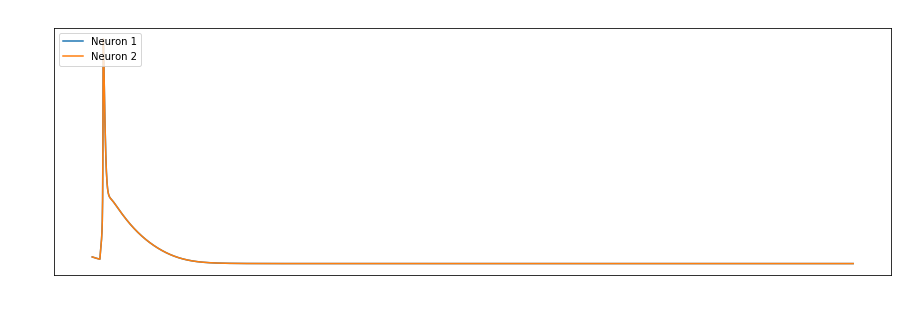

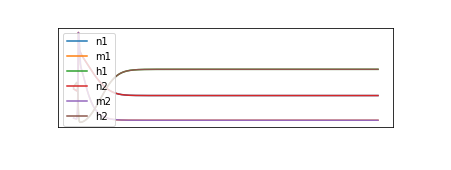

In [11]:
g1 = 0.1
g2 = g1
s1 = 0.006037
s2 = s1

tvec_start = 0
tvec_end_BURN = 50 #ms
tvec_end = 500
num_points = 5000
#Values to be passed in for generating an applied current:
t_start_CURRENT = 5 #ms
t_end_CURRENT = 7 #ms
amplitude_CURRENT = 0.1 #Amps (per cm^2?)

t = np.linspace(tvec_start,tvec_end_BURN,num_points) #ms
vI_scn = [t_start_CURRENT,t_end_CURRENT,amplitude_CURRENT,g1,g2]
#initial condition: V, n, m, h, s
V1 = -58; V2 = -58
n1 = 0.05; n2 = 0.05
m1 = 0.33; m2 = 0.33
h1 = 0.6; h2 = 0.6
#s1 = 0.5; s2 = 0.5
x0_scn = [V1, n1, m1, h1, s1, V2, n2, m2, h2, s2]

#Burn in run
x_scn = odeint(odes_scn,x0_scn,t,args=(I,vI_scn))
x_scn = np.transpose(x_scn)
#plot_vnmh(x_scn,t)

t = np.linspace(tvec_start,tvec_end,num_points) #ms
vI_scn = [t_start_CURRENT,t_end_CURRENT,amplitude_CURRENT,g1,g2]
#initial condition: V, n, m, h, s 
#Commented values are for g=0
V1 = x_scn[0,-1] #-6.00471422e+01
n1 = x_scn[1,-1] #3.16954741e-01
m1 = x_scn[2,-1] #5.26388943e-02
h1 = x_scn[3,-1] #5.97768455e-01
s1 = x_scn[4,-1] #-3.81327848e-11

V2 = x_scn[5,-1] #-6.00471422e+01 #Same as Neur1
n2 = x_scn[6,-1] #3.16954741e-01 #Same as Neur1
m2 = x_scn[7,-1] #5.26388943e-02 #Same as Neur1
h2 = x_scn[8,-1] #5.97768455e-01 #Same as Neur1
s2 = x_scn[9,-1] #-3.81327848e-11 #Same as Neur1

#print(x_scn[:,-1])

#s_initial, s_final
#1, 0.007440221187101991
#1.5, 0.00814638689804401
#0.5, 0.006734116199199403
#0.2, 0.006310429589380202
#0.8, 0.007157800263585501
#0.007, 0.006037885217584234
#0.006, 0.006036470657299054

x0_scn = [V1, n1, m1, h1, s1, V2, n2, m2, h2, s2]

x_scn = odeint(odes_scn,x0_scn,t,args=(I,vI_scn))
x_scn = np.transpose(x_scn)
plot_vnmh(x_scn,t)

Iter 0/1000: max V1 for g of 0.00000 is 45.163
No 2nd peak found
--------------------------------
Iter 1/1000: max V1 for g of 0.00501 is 42.863
No 2nd peak found
--------------------------------
Iter 2/1000: max V1 for g of 0.01001 is 40.825
No 2nd peak found
--------------------------------
Iter 3/1000: max V1 for g of 0.01502 is 38.939
No 2nd peak found
--------------------------------
Iter 4/1000: max V1 for g of 0.02002 is 37.154
No 2nd peak found
--------------------------------
Iter 5/1000: max V1 for g of 0.02503 is 35.441
No 2nd peak found
--------------------------------
Iter 6/1000: max V1 for g of 0.03003 is 33.789
No 2nd peak found
--------------------------------
Iter 7/1000: max V1 for g of 0.03504 is 32.187
No 2nd peak found
--------------------------------
Iter 8/1000: max V1 for g of 0.04004 is 30.631
No 2nd peak found
--------------------------------
Iter 9/1000: max V1 for g of 0.04505 is 29.108
No 2nd peak found
--------------------------------
Iter 10/1000: max V1

Iter 83/1000: max V1 for g of 0.41542 is 5.002
No 2nd peak found
--------------------------------
Iter 84/1000: max V1 for g of 0.42042 is 5.270
No 2nd peak found
--------------------------------
Iter 85/1000: max V1 for g of 0.42543 is 5.536
No 2nd peak found
--------------------------------
Iter 86/1000: max V1 for g of 0.43043 is 5.799
No 2nd peak found
--------------------------------
Iter 87/1000: max V1 for g of 0.43544 is 6.059
No 2nd peak found
--------------------------------
Iter 88/1000: max V1 for g of 0.44044 is 6.316
No 2nd peak found
--------------------------------
Iter 89/1000: max V1 for g of 0.44545 is 6.571
No 2nd peak found
--------------------------------
Iter 90/1000: max V1 for g of 0.45045 is 6.824
No 2nd peak found
--------------------------------
Iter 91/1000: max V1 for g of 0.45546 is 7.073
No 2nd peak found
--------------------------------
Iter 92/1000: max V1 for g of 0.46046 is 7.320
No 2nd peak found
--------------------------------
Iter 93/1000: max V1

Iter 166/1000: max V1 for g of 0.83083 is 20.567
No 2nd peak found
--------------------------------
Iter 167/1000: max V1 for g of 0.83584 is 20.696
No 2nd peak found
--------------------------------
Iter 168/1000: max V1 for g of 0.84084 is 20.825
No 2nd peak found
--------------------------------
Iter 169/1000: max V1 for g of 0.84585 is 20.953
No 2nd peak found
--------------------------------
Iter 170/1000: max V1 for g of 0.85085 is 21.079
No 2nd peak found
--------------------------------
Iter 171/1000: max V1 for g of 0.85586 is 21.205
No 2nd peak found
--------------------------------
Iter 172/1000: max V1 for g of 0.86086 is 21.330
No 2nd peak found
--------------------------------
Iter 173/1000: max V1 for g of 0.86587 is 21.454
No 2nd peak found
--------------------------------
Iter 174/1000: max V1 for g of 0.87087 is 21.577
No 2nd peak found
--------------------------------
Iter 175/1000: max V1 for g of 0.87588 is 21.700
No 2nd peak found
--------------------------------


Iter 248/1000: max V1 for g of 1.24124 is 28.811
No 2nd peak found
--------------------------------
Iter 249/1000: max V1 for g of 1.24625 is 28.817
No 2nd peak found
--------------------------------
Iter 250/1000: max V1 for g of 1.25125 is 28.893
No 2nd peak found
--------------------------------
Iter 251/1000: max V1 for g of 1.25626 is 28.968
No 2nd peak found
--------------------------------
Iter 252/1000: max V1 for g of 1.26126 is 29.043
No 2nd peak found
--------------------------------
Iter 253/1000: max V1 for g of 1.26627 is 29.117
No 2nd peak found
--------------------------------
Iter 254/1000: max V1 for g of 1.27127 is 29.191
No 2nd peak found
--------------------------------
Iter 255/1000: max V1 for g of 1.27628 is 29.265
No 2nd peak found
--------------------------------
Iter 256/1000: max V1 for g of 1.28128 is 29.338
No 2nd peak found
--------------------------------
Iter 257/1000: max V1 for g of 1.28629 is 29.411
No 2nd peak found
--------------------------------


Iter 330/1000: max V1 for g of 1.65165 is 33.808
No 2nd peak found
--------------------------------
Iter 331/1000: max V1 for g of 1.65666 is 33.858
No 2nd peak found
--------------------------------
Iter 332/1000: max V1 for g of 1.66166 is 33.907
No 2nd peak found
--------------------------------
Iter 333/1000: max V1 for g of 1.66667 is 33.957
No 2nd peak found
--------------------------------
Iter 334/1000: max V1 for g of 1.67167 is 34.006
No 2nd peak found
--------------------------------
Iter 335/1000: max V1 for g of 1.67668 is 34.055
No 2nd peak found
--------------------------------
Iter 336/1000: max V1 for g of 1.68168 is 34.104
No 2nd peak found
--------------------------------
Iter 337/1000: max V1 for g of 1.68669 is 34.152
No 2nd peak found
--------------------------------
Iter 338/1000: max V1 for g of 1.69169 is 34.201
No 2nd peak found
--------------------------------
Iter 339/1000: max V1 for g of 1.69670 is 34.249
No 2nd peak found
--------------------------------


Iter 412/1000: max V1 for g of 2.06206 is 37.296
No 2nd peak found
--------------------------------
Iter 413/1000: max V1 for g of 2.06707 is 37.331
No 2nd peak found
--------------------------------
Iter 414/1000: max V1 for g of 2.07207 is 37.320
No 2nd peak found
--------------------------------
Iter 415/1000: max V1 for g of 2.07708 is 37.401
No 2nd peak found
--------------------------------
Iter 416/1000: max V1 for g of 2.08208 is 37.390
No 2nd peak found
--------------------------------
Iter 417/1000: max V1 for g of 2.08709 is 37.470
No 2nd peak found
--------------------------------
Iter 418/1000: max V1 for g of 2.09209 is 37.504
No 2nd peak found
--------------------------------
Iter 419/1000: max V1 for g of 2.09710 is 37.539
No 2nd peak found
--------------------------------
Iter 420/1000: max V1 for g of 2.10210 is 37.573
No 2nd peak found
--------------------------------
Iter 421/1000: max V1 for g of 2.10711 is 37.562
No 2nd peak found
--------------------------------


Iter 494/1000: max V1 for g of 2.47247 is 39.779
No 2nd peak found
--------------------------------
Iter 495/1000: max V1 for g of 2.47748 is 39.805
No 2nd peak found
--------------------------------
Iter 496/1000: max V1 for g of 2.48248 is 39.792
No 2nd peak found
--------------------------------
Iter 497/1000: max V1 for g of 2.48749 is 39.856
No 2nd peak found
--------------------------------
Iter 498/1000: max V1 for g of 2.49249 is 39.882
No 2nd peak found
--------------------------------
Iter 499/1000: max V1 for g of 2.49750 is 39.908
No 2nd peak found
--------------------------------
Iter 501/1000: max V1 for g of 2.50250 is 39.934
No 2nd peak found
--------------------------------
Iter 502/1000: max V1 for g of 2.50751 is 39.959
No 2nd peak found
--------------------------------
Iter 503/1000: max V1 for g of 2.51251 is 39.984
No 2nd peak found
--------------------------------
Iter 504/1000: max V1 for g of 2.51752 is 39.971
No 2nd peak found
--------------------------------


Iter 577/1000: max V1 for g of 2.88288 is 41.623
No 2nd peak found
--------------------------------
Iter 578/1000: max V1 for g of 2.88789 is 41.643
No 2nd peak found
--------------------------------
Iter 579/1000: max V1 for g of 2.89289 is 41.663
No 2nd peak found
--------------------------------
Iter 580/1000: max V1 for g of 2.89790 is 41.683
No 2nd peak found
--------------------------------
Iter 581/1000: max V1 for g of 2.90290 is 41.703
No 2nd peak found
--------------------------------
Iter 582/1000: max V1 for g of 2.90791 is 41.723
No 2nd peak found
--------------------------------
Iter 583/1000: max V1 for g of 2.91291 is 41.743
No 2nd peak found
--------------------------------
Iter 584/1000: max V1 for g of 2.91792 is 41.763
No 2nd peak found
--------------------------------
Iter 585/1000: max V1 for g of 2.92292 is 41.782
No 2nd peak found
--------------------------------
Iter 586/1000: max V1 for g of 2.92793 is 41.802
No 2nd peak found
--------------------------------


Iter 659/1000: max V1 for g of 3.29329 is 43.097
No 2nd peak found
--------------------------------
Iter 660/1000: max V1 for g of 3.29830 is 43.113
No 2nd peak found
--------------------------------
Iter 661/1000: max V1 for g of 3.30330 is 43.129
No 2nd peak found
--------------------------------
Iter 662/1000: max V1 for g of 3.30831 is 43.145
No 2nd peak found
--------------------------------
Iter 663/1000: max V1 for g of 3.31331 is 43.161
No 2nd peak found
--------------------------------
Iter 664/1000: max V1 for g of 3.31832 is 43.177
No 2nd peak found
--------------------------------
Iter 665/1000: max V1 for g of 3.32332 is 43.192
No 2nd peak found
--------------------------------
Iter 666/1000: max V1 for g of 3.32833 is 43.208
No 2nd peak found
--------------------------------
Iter 667/1000: max V1 for g of 3.33333 is 43.224
No 2nd peak found
--------------------------------
Iter 668/1000: max V1 for g of 3.33834 is 43.240
No 2nd peak found
--------------------------------


Iter 742/1000: max V1 for g of 3.70871 is 44.295
No 2nd peak found
--------------------------------
Iter 743/1000: max V1 for g of 3.71371 is 44.308
No 2nd peak found
--------------------------------
Iter 744/1000: max V1 for g of 3.71872 is 44.321
No 2nd peak found
--------------------------------
Iter 745/1000: max V1 for g of 3.72372 is 44.334
No 2nd peak found
--------------------------------
Iter 746/1000: max V1 for g of 3.72873 is 44.347
No 2nd peak found
--------------------------------
Iter 747/1000: max V1 for g of 3.73373 is 44.360
No 2nd peak found
--------------------------------
Iter 748/1000: max V1 for g of 3.73874 is 44.373
No 2nd peak found
--------------------------------
Iter 749/1000: max V1 for g of 3.74374 is 44.386
No 2nd peak found
--------------------------------
Iter 750/1000: max V1 for g of 3.74875 is 44.398
No 2nd peak found
--------------------------------
Iter 751/1000: max V1 for g of 3.75375 is 44.411
No 2nd peak found
--------------------------------


Iter 824/1000: max V1 for g of 4.11912 is 45.267
No 2nd peak found
--------------------------------
Iter 825/1000: max V1 for g of 4.12412 is 45.277
No 2nd peak found
--------------------------------
Iter 826/1000: max V1 for g of 4.12913 is 45.288
No 2nd peak found
--------------------------------
Iter 827/1000: max V1 for g of 4.13413 is 45.299
No 2nd peak found
--------------------------------
Iter 828/1000: max V1 for g of 4.13914 is 45.310
No 2nd peak found
--------------------------------
Iter 829/1000: max V1 for g of 4.14414 is 45.320
No 2nd peak found
--------------------------------
Iter 830/1000: max V1 for g of 4.14915 is 45.331
No 2nd peak found
--------------------------------
Iter 831/1000: max V1 for g of 4.15415 is 45.342
No 2nd peak found
--------------------------------
Iter 832/1000: max V1 for g of 4.15916 is 45.352
No 2nd peak found
--------------------------------
Iter 833/1000: max V1 for g of 4.16416 is 45.363
No 2nd peak found
--------------------------------


Iter 906/1000: max V1 for g of 4.52953 is 46.079
No 2nd peak found
--------------------------------
Iter 907/1000: max V1 for g of 4.53453 is 46.088
No 2nd peak found
--------------------------------
Iter 908/1000: max V1 for g of 4.53954 is 46.097
No 2nd peak found
--------------------------------
Iter 909/1000: max V1 for g of 4.54454 is 46.106
No 2nd peak found
--------------------------------
Iter 910/1000: max V1 for g of 4.54955 is 46.115
No 2nd peak found
--------------------------------
Iter 911/1000: max V1 for g of 4.55455 is 46.124
No 2nd peak found
--------------------------------
Iter 912/1000: max V1 for g of 4.55956 is 46.133
No 2nd peak found
--------------------------------
Iter 913/1000: max V1 for g of 4.56456 is 46.142
No 2nd peak found
--------------------------------
Iter 914/1000: max V1 for g of 4.56957 is 46.151
No 2nd peak found
--------------------------------
Iter 915/1000: max V1 for g of 4.57457 is 46.160
No 2nd peak found
--------------------------------


Iter 988/1000: max V1 for g of 4.93994 is 46.768
No 2nd peak found
--------------------------------
Iter 989/1000: max V1 for g of 4.94494 is 46.776
No 2nd peak found
--------------------------------
Iter 990/1000: max V1 for g of 4.94995 is 46.783
No 2nd peak found
--------------------------------
Iter 991/1000: max V1 for g of 4.95495 is 46.791
No 2nd peak found
--------------------------------
Iter 992/1000: max V1 for g of 4.95996 is 46.799
No 2nd peak found
--------------------------------
Iter 993/1000: max V1 for g of 4.96496 is 46.807
No 2nd peak found
--------------------------------
Iter 994/1000: max V1 for g of 4.96997 is 46.814
No 2nd peak found
--------------------------------
Iter 995/1000: max V1 for g of 4.97497 is 46.822
No 2nd peak found
--------------------------------
Iter 996/1000: max V1 for g of 4.97998 is 46.830
No 2nd peak found
--------------------------------
Iter 997/1000: max V1 for g of 4.98498 is 46.837
No 2nd peak found
--------------------------------


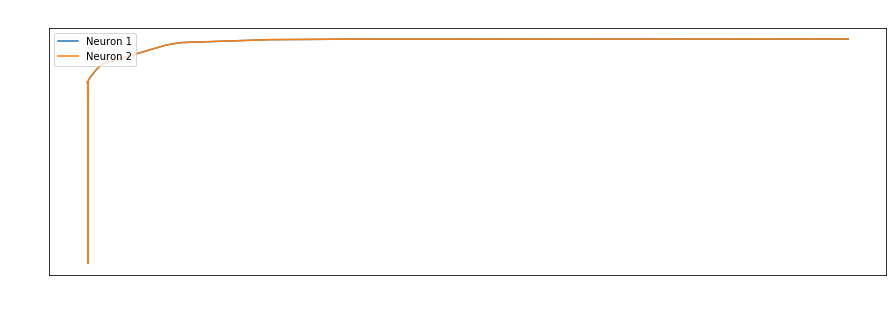

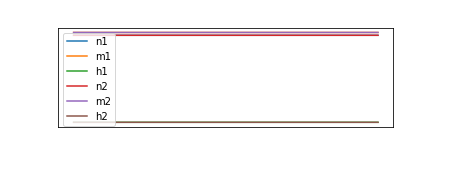

In [14]:
#Procedurally verifying whether we can get periodic APs

#constants
s1 = 0.006037
s2 = s1

tvec_start = 0
tvec_end_BURN = 30 #ms
tvec_end = 30
num_points = 5000
#Values to be passed in for generating an applied current:
t_start_CURRENT = 5 #ms
t_end_CURRENT = 7 #ms
amplitude_CURRENT = 0.1 #Amps (per cm^2?)

t = np.linspace(tvec_start,tvec_end_BURN,num_points) #ms
    
gMin = 0
gMax = 5
gPoints = 1000
#Actual "function"
gRange = np.linspace(gMin,gMax,gPoints)
for gVal in gRange:
    g1 = gVal
    g2 = g1
    
    vI_scn = [t_start_CURRENT,t_end_CURRENT,amplitude_CURRENT,g1,g2]
    #initial condition: V, n, m, h, s
    V1 = -58; V2 = -58
    n1 = 0.05; n2 = 0.05
    m1 = 0.33; m2 = 0.33
    h1 = 0.6; h2 = 0.6
    x0_scn = [V1, n1, m1, h1, s1, V2, n2, m2, h2, s2]
    
    #Burn in run
    x_scn = odeint(odes_scn,x0_scn,t,args=(I,vI_scn))
    x_scn = np.transpose(x_scn)
    
    t = np.linspace(tvec_start,tvec_end,num_points) #ms
    vI_scn = [t_start_CURRENT,t_end_CURRENT,amplitude_CURRENT,g1,g2]
    #initial condition: V, n, m, h, s
    V1 = x_scn[0,-1] 
    n1 = x_scn[1,-1] 
    m1 = x_scn[2,-1] 
    h1 = x_scn[3,-1] 
    s1 = x_scn[4,-1] 
    V2 = x_scn[5,-1] 
    n2 = x_scn[6,-1] 
    m2 = x_scn[7,-1] 
    h2 = x_scn[8,-1] 
    s2 = x_scn[9,-1] 
    x0_scn = [V1, n1, m1, h1, s1, V2, n2, m2, h2, s2]
    
    #Actual run
    x_scn = odeint(odes_scn,x0_scn,t,args=(I,vI_scn))
    x_scn = np.transpose(x_scn)
    
    #Results
    V1_vec = x_scn[0,:]
    V2_vec = x_scn[5,:]
    diffV = np.subtract(V1_vec,V2_vec)
    arbThresh = 0.005
    if (diffV[0]<arbThresh and diffV[-1]<arbThresh):
        #Then V1 and V2 are the same
        pass
    else:
        print("V1 not equal to V2")
    
    V1_vec = V1_vec.tolist()
    max_val = max(V1_vec)
    max_idx = V1_vec.index(max_val)
    my_string = "Iter {my_iter:.0f}/{total}: max V1 for g of {temp_g:.5f} is {max_val:.3f}"
    print(my_string.format(my_iter = gVal/gMax*gPoints, total = gPoints, temp_g = gVal, max_val = max_val))
    
    for nextV in V1_vec[(max_idx+25):]:
        if nextV>=max_val:
            print("Second spike found?")
            print(nextV)
            print(max_val)
            print("--------------------------------")
            plot_vnmh(x_scn,t)
            break
            
    print("No 2nd peak found")
    print("--------------------------------")
    
plot_vnmh(x_scn,t)

## Questions to answer
1. Are g1 and g2 the same or different?
   - I would assume the same
2. What are the equations for ds/dt?
3. Are s1 and s2 the same?
   - I would assume the same
4. Should V1 and V2 (and other ICs) be the same between the neurons?
   - I would assume the same